In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

In [3]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FitPulse_cleaned.csv')
df.head(90)

,time_stamp,heart_rate,step_count,sleep_tracking,Patient_ID,Weight,Height
0,2025-01-14 16:50:00,74.499653,26.0,awake,P0001,88,168
1,2025-01-21 08:55:00,90.833116,6.0,awake,P0002,78,162
2,2025-01-17 07:10:00,61.270774,40.0,awake,P0003,64,162
3,2025-01-18 18:25:00,59.807869,29.0,exercise,P0005,70,151
4,2025-01-13 07:20:00,92.702179,34.0,awake,P0006,88,159
...,...,...,...,...,...,...,...
85,2025-01-23 06:45:00,88.237084,29.0,awake,P0096,58,172
86,2025-01-23 19:25:00,68.061079,34.0,exercise,P0097,57,172
87,2025-01-04 05:15:00,71.706535,33.0,sleep,P0098,61,170
88,2025-01-21 22:45:00,84.793411,9.0,awake,P0100,82,158


In [4]:
# Convert timestamp to datetime
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [5]:
# Sort by time
df = df.sort_values('time_stamp')

In [8]:
# 2. Select Metric for Anomaly Detection

# Using heart_rate for anomaly detection
metric = 'heart_rate'

In [9]:
# 3. Rule-Based Anomaly Detection (Threshold)

mean_val = df[metric].mean()
std_val = df[metric].std()

upper_threshold = mean_val + 3 * std_val
lower_threshold = mean_val - 3 * std_val

df['threshold_anomaly'] = (
    (df[metric] > upper_threshold) |
    (df[metric] < lower_threshold)
)

In [11]:
# 4. Clustering-Based Anomaly Detection (KMeans)

X = df[[metric]].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Distance from cluster center
centers = kmeans.cluster_centers_
distances = np.linalg.norm(X_scaled - centers[df['cluster']], axis=1)

# Mark top 5% farthest points as anomalies
distance_threshold = np.percentile(distances, 95)
df['cluster_anomaly'] = distances > distance_threshold

In [12]:
# 5. Prophet Residual-Based Anomaly Detection

prophet_df = df[['time_stamp', metric]]
prophet_df.columns = ['ds', 'y']

model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

forecast = model.predict(prophet_df)

# Residual calculation
df['residual'] = prophet_df['y'] - forecast['yhat']

residual_threshold = 3 * df['residual'].std()
df['prophet_anomaly'] = abs(df['residual']) > residual_threshold

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [13]:
# 6. Final Anomaly Flag (Combine All)

df['final_anomaly'] = (
    df['threshold_anomaly'] |
    df['cluster_anomaly'] |
    df['prophet_anomaly']
)

print("\nSample detected anomalies:")
print(df[df['final_anomaly']].head())


Sample detected anomalies:
              time_stamp  heart_rate  step_count sleep_tracking Patient_ID  \
5730 2025-01-01 01:40:00   49.925289        32.0          sleep      P6283   
145  2025-01-01 02:45:00   50.279561         3.0          sleep      P0164   
1582 2025-01-01 08:55:00   94.655206         1.0          awake      P1739   
3468 2025-01-01 09:25:00   44.715143        16.0          awake      P3804   
5833 2025-01-01 10:40:00   92.012312        18.0          awake      P6394   

      Weight  Height  threshold_anomaly  cluster  cluster_anomaly   residual  \
5730      58     159              False        2             True -22.216309   
145       64     183              False        2             True -21.726698   
1582      78     176              False        1             True  22.426907   
3468      54     155              False        2             True -27.388784   
5833      64     179              False        1             True  20.243252   

      prophet_anomaly 

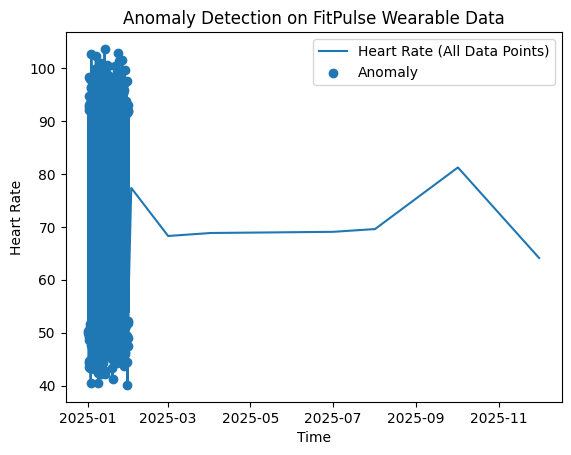

In [14]:
# 7. Visualization – ENTIRE DATASET

# Plot all datapoints
plt.plot(
    df['time_stamp'],
    df[metric],
    label='Heart Rate (All Data Points)'
)

# Highlight anomalies
plt.scatter(
    df[df['final_anomaly']]['time_stamp'],
    df[df['final_anomaly']][metric],
    label='Anomaly'
)

plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Anomaly Detection on FitPulse Wearable Data")
plt.legend()
plt.show()

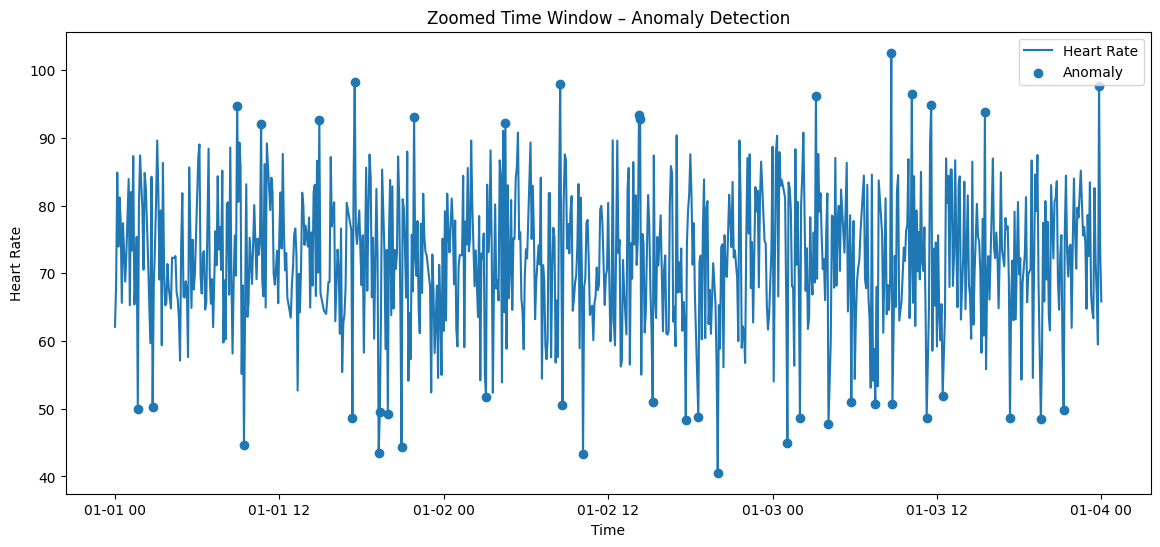

In [15]:
# 8. Time Window Visualization (Optional)

window_df = df[
    (df['time_stamp'] >= df['time_stamp'].min()) &
    (df['time_stamp'] <= df['time_stamp'].min() + pd.Timedelta(days=3))
]

plt.figure(figsize=(14, 6))
plt.plot(window_df['time_stamp'], window_df[metric], label='Heart Rate')
plt.scatter(
    window_df[window_df['final_anomaly']]['time_stamp'],
    window_df[window_df['final_anomaly']][metric],
    label='Anomaly'
)
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Zoomed Time Window – Anomaly Detection")
plt.legend()
plt.show()